# Latent Dirichlet Allocation (LDA)

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import numpy.linalg as LA
import random as r
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import time
import itertools
from tqdm.notebook import tqdm
from gensim import corpora, models, matutils
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel
from collections import defaultdict
import re
import emoji
from nltk.corpus import stopwords
import nltk
import math
from wordcloud import WordCloud

# 1. Data
## 1.1. Data processing
Embassy : US (= 1), CN (= 2) or UK (= 3)  
Language: English  
※ Convert the posting time to UNIX time, and rewrite it as the elapsed time (the number of days that have elapsed including seconds).  
※ Delete "beijingair" account.  
※ Tweets successively posted by the same account within 300 second are merged.  
※ Quoted Tweets are merged with the original tweet.

In [2]:
def transposeDate(date):
    month = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    monthNum = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    textDate = [[word for word in date.lower().split()] for date in date]
    elapsedTime = []
    for i in range(len(date)):
        for m in range(12):
            if month[m]==textDate[i][1]:
                elapsedTime.append(textDate[i][4]+"-"+monthNum[m]+"-"+textDate[i][2]+" "+textDate[i][3])
                break
            if m==11:
                print("erorr")
    return elapsedTime
def deleteStopAccount(data, stopAccount):
    idx = []
    for i in range(data.shape[0]):
        if any([nam == data.loc[i,"Screen_name"] for nam in stopAccount]):
            idx.append(i)
        continue
    return data.drop(idx).reset_index(drop=True)
def deleteSamePost(data, time=300):
    idx = []
    i = 1
    while i < data.shape[0]:
        cnt = 0
        if (data["Elapsed_time"][i]<=data["Elapsed_time"][i-1]+time/24/60/60)&(data["Screen_name"][i]==data["Screen_name"][i-1]):
            while (data.loc[i+cnt, "Elapsed_time"]<=data.loc[i-1, "Elapsed_time"]+time/24/60/60)&(data.loc[i+cnt, "Screen_name"]==data.loc[i-1, "Screen_name"]):
                idx.append(i+cnt)
                data.loc[i-1, "Tweet_text"] = data.loc[i-1, "Tweet_text"] + " " + data.loc[i+cnt, "Tweet_text"]
                cnt+=1
        i += cnt+1
    return data.drop(idx).reset_index(drop=True)
def mergeQuoted(data):
    data.loc[(data['Typer']=='quoted')&(data['Orig_tweet_lang']=='en'),'Tweet_text'] = data.loc[(data['Typer']=='quoted')&(data['Orig_tweet_lang']=='en'),'Orig_tweet_text'] + ' ' + data.loc[(data['Typer']=='quoted')&(data['Orig_tweet_lang']=='en'),'Tweet_text']
    return data

In [3]:
'''
col_names = ['Date&Time', 'Tweet_id', 'Embassy', 'Address', 'Screen_name', 'Tweet_lang', 'Orig_tweet_lang', 'Typer', 'Orig_tweet_id', 'Orig_screen_name', 'Tweet_text', 'Orig_tweet_text']
rawData = pd.read_csv('Target_tweet_Embassies20200201_0927.csv', sep="	", names=col_names, encoding="utf-16")
rawData
stopAccount = ["beijingair"]
data = rawData[((rawData["Embassy"]=="US")|(rawData["Embassy"]=="CN")|(rawData["Embassy"]=="GB"))&(rawData["Tweet_lang"]=="en")].reset_index(drop=True)
data = deleteStopAccount(data, stopAccount)
data['label'] = (data["Embassy"]=="CN") + (data["Embassy"]=="GB")*2+1
data['Elapsed_time'] = (pd.to_datetime(transposeDate(data['Date&Time'])).astype(int) // 10**9 - min(pd.to_datetime(transposeDate(data['Date&Time'])).astype(int)) // 10**9)/(60*60*24)
data = data.sort_values(by="Elapsed_time", ascending=True).reset_index().drop('index', axis=1)
data = deleteSamePost(data)
data = mergeQuoted(data)
data.to_csv('data_USCNGB.csv')
'''
data = pd.read_csv('data_USCNGB.csv')
data

,Unnamed: 0,Date&Time,Tweet_id,Embassy,Address,Screen_name,Tweet_lang,Orig_tweet_lang,Typer,Orig_tweet_id,Orig_screen_name,Tweet_text,Orig_tweet_text,label,Elapsed_time
0,0,Fri Jan 31 15:01:05 2020,1223259914627358727,US,NO,usembassyoslo,en,NaN,NaN,NaN,NaN,To commemorate the 75th anniversary of the est...,NaN,1,0.000000
1,1,Fri Jan 31 15:02:22 2020,1223260240046632960,US,CA,usembassyottawa,en,NaN,NaN,NaN,NaN,#DYK @FVAP is the only official U.S. gov't pro...,NaN,1,0.000891
2,2,Fri Jan 31 15:40:01 2020,1223269713897238528,US,PK,usembislamabad,en,en,quoted,1153687986598490112,IREXintl,.@UGRADPakistan alum Abdul is an advocate for ...,.@UGRADPakistan alum Abdul is an advocate for ...,1,0.027037
3,3,Fri Jan 31 15:40:50 2020,1223269917383970822,US,CA,usembassyottawa,en,NaN,reply,1223263227527794691,CAFinUS,@CAFinUS Looks... brisk 🥶 😅,NaN,1,0.027604
4,4,Fri Jan 31 15:40:50 2020,1223269920143761408,CN,AT,li_xiaosi,en,en,quoted,1219935806632157184,li_xiaosi,German virologist Jonas Schmidt-Chanasit on #c...,German virologist Jonas Schmidt-Chanasit on #c...,2,0.027604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124089,124089,Wed Sep 30 23:25:02 2020,1311446990388113408,US,SG,redwhitebluedot,en,NaN,NaN,NaN,NaN,October is #CybersecurityAwarenessMonth with t...,NaN,1,243.349965
124090,124090,Wed Sep 30 23:36:10 2020,1311449793265246208,CN,CA,chinacgcalgary,en,NaN,NaN,NaN,NaN,"Dear friends, please kindly click the link bel...",NaN,2,243.357697
124091,124091,Wed Sep 30 23:45:18 2020,1311452090103934978,GB,AU,ukinaustralia,en,en,quoted,1311233633424900097,jcookfcdo,So pleased to present ⁦@raelenecastle⁩ with th...,So pleased to present ⁦@raelenecastle⁩ with th...,3,243.364039
124092,124092,Wed Sep 30 23:59:28 2020,1311455657187565568,GB,AU,ukinaustralia,en,en,quoted,1311253699491135494,WHO,The Access to #COVID19 Tools (ACT) Accelerator...,The Access to #COVID19 Tools (ACT) Accelerator...,3,243.373877


## 1.2. Make Dictionary and Corpus
We use the stopwords prepared in nltk, some symbol, emoji mentions and url.  
We also delete low TF-IDF words besides "covid-19".

In [4]:
stop_symbols = ['\'s', '\”','\”', '\"', '\(', '\)', '\:', '\;', '\!', '\?', '\.', '\,']
tweets = data["Tweet_text"].tolist()
for n in range(len(tweets)):
    tw = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', tweets[n].lower()) # delete url.
    tw = re.sub('@[A-Za-z0-9]+', '', tw) # delete mentions.
    tw = re.sub('#', '', tw) # delete a hashtag symbol '#'.
    for symbol in stop_symbols: # delete symbols.
        tw = re.sub(symbol, '', tw) # delete symbols.
    tw = re.sub('xi jinping', 'xijinping', tw) # get one word 'xijinping'
    tw = re.sub('hong kong', 'hongkong', tw) # get one word 'hongkong'
    tw = re.sub('black lives matter', 'blacklivesmatter', tw) # get one word 'black lives matter'
    tweets[n] = ''.join([c for c in tw if c not in emoji.UNICODE_EMOJI["en"]]) # delete emoji.  

In [5]:
'''
def getTF_IDF(corpus, dictionary):
    test_model = models.TfidfModel(corpus)
    corpus_tfidf = test_model[corpus]
    texts_tfidf = pd.DataFrame(columns=['word', 'tf-idf', 'count'])
    for doc in tqdm(corpus_tfidf):
        for d in doc:
            word = dictionary[d[0]]
            tfidf = d[1]
            if any(texts_tfidf['word']==word):
                texts_tfidf[texts_tfidf['word']==word] = texts_tfidf[texts_tfidf['word']==word] + ['', tfidf, 1]
            else:
                df = pd.DataFrame(data=[[word, tfidf, 1]], columns=['word', 'tf-idf', 'count'])
                texts_tfidf = texts_tfidf.append(df, ignore_index = True)
    texts_tfidf['ave_tf-idf'] = texts_tfidf['tf-idf']/texts_tfidf['count']
    return texts_tfidf

#nltk.download('stopwords') 2021.7.8
stopwords_nltk = stopwords.words('english')
stopwords_symbol = ['-', '&', '/', '→','+','-','.:','️', '&amp', "1/2", "2/2"]
stopWords = set(stopwords_nltk+stopwords_symbol) #new stopwords
texts = [[word for word in tweets.split() if word not in stopWords] for tweets in tweets]
texts = [['covid-19' if ('covid' in word) else word for word in txt] for txt in texts] # converting to 'covid-19' 
texts = [[word for word in txt if word not in stopWords] for txt in texts]
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=10) # appear more that 10 times
corpus = [dictionary.doc2bow(text) for text in texts]
tf_idf = getTF_IDF(corpus, dictionary)
tf_idf.to_csv('tf_idfUSCNGB.csv')
'''

'\ndef getTF_IDF(corpus, dictionary):\n    test_model = models.TfidfModel(corpus)\n    corpus_tfidf = test_model[corpus]\n    texts_tfidf = pd.DataFrame(columns=[\'word\', \'tf-idf\', \'count\'])\n    for doc in tqdm(corpus_tfidf):\n        for d in doc:\n            word = dictionary[d[0]]\n            tfidf = d[1]\n            if any(texts_tfidf[\'word\']==word):\n                texts_tfidf[texts_tfidf[\'word\']==word] = texts_tfidf[texts_tfidf[\'word\']==word] + [\'\', tfidf, 1]\n            else:\n                df = pd.DataFrame(data=[[word, tfidf, 1]], columns=[\'word\', \'tf-idf\', \'count\'])\n                texts_tfidf = texts_tfidf.append(df, ignore_index = True)\n    texts_tfidf[\'ave_tf-idf\'] = texts_tfidf[\'tf-idf\']/texts_tfidf[\'count\']\n    return texts_tfidf\n\n#nltk.download(\'stopwords\') 2021.7.8\nstopwords_nltk = stopwords.words(\'english\')\nstopwords_symbol = [\'-\', \'&\', \'/\', \'→\',\'+\',\'-\',\'.:\',\'️\', \'&amp\', "1/2", "2/2"]\nstopWords = set(stopw

In [6]:
tf_idf = pd.read_csv('tf_idfUSCNGB.csv')

#nltk.download('stopwords') 2021.7.8
stopwords_nltk = stopwords.words('english')
stopwords_symbol = ['-', '&', '/', '→','+','-','.:','️', '&amp', "1/2", "2/2"]
stopwords_tfidf = tf_idf[(tf_idf['ave_tf-idf']<0.14)&(tf_idf['word']!='covid-19')&(tf_idf['word']!='coronavirus')&(tf_idf['word']!='pandemic')]['word'].tolist()
stopWords = set(stopwords_nltk+stopwords_symbol+stopwords_tfidf) #new stopwords

texts = [[word for word in tweets.split() if word not in stopWords] for tweets in tweets]
texts = [['covid-19' if ('covid' in word) else word for word in txt] for txt in texts] # converting to 'covid-19' 
texts = [[word for word in txt if word not in stopWords] for txt in texts]
    
dictionary = Dictionary(texts)
dictionary.filter_extremes(no_below=10) # appear more that 10 times
corpus = [dictionary.doc2bow(text) for text in texts]

print('vocab size: ', len(dictionary), end='\n\n')
print('Example: ', end='\n\n')
for i in range(3):
    print("●Tweets: ")
    print(tweets[i], end='\n')
    print("●Words: ")
    print(texts[i], end='\n\n')

vocab size:  16422

Example: 

●Tweets: 
to commemorate the 75th anniversary of the establishment of the  us ambassador kenneth j braithwaite and norwegian ambassador to the us  celebrated with a joint f16 flight in aircraft operated by 132ndairwing stationed at bodøairbase wearenato 
●Words: 
['commemorate', '75th', 'anniversary', 'establishment', 'ambassador', 'kenneth', 'j', 'braithwaite', 'norwegian', 'ambassador', 'celebrated', 'joint', 'f16', 'flight', 'aircraft', 'operated', '132ndairwing', 'stationed', 'bodøairbase', 'wearenato']

●Tweets: 
dyk  is the only official us gov't program focused on sharing accurate non-partisan absentee voting assistance for uscits  regardless of where you are in the world  resources are available to assist you with the absentee voting process   
●Words: 
['dyk', 'official', "gov't", 'program', 'focused', 'sharing', 'accurate', 'non-partisan', 'absentee', 'voting', 'assistance', 'uscits', 'regardless', 'resources', 'available', 'assist', 'absentee',

# 2. LDA
1. $N$ : Number of words. Poisson distribution with intensity $\xi$.
2. $\Theta$ : Distribution of Topic. Dirichelt distribution with parameter $\alpha$.
3. Each word $w_1, \dots, w_N$ is generated as below:  
a) $z_n$ : Topic of the n-th word, which is generated by Multinomial distribution with parameter $\Theta$.  
b) $w_n$ : The n-th word which is generated some probability $p(w_n|z_n, \beta)$ where $\beta$ is parameter.

### Comparison of Perplexity and Coherence.

$Perplexity = \exp\Bigg(-\frac{1}{N}\sum_{n=1}^N \log_2 p(w_n)\Bigg)$, where $N$ is vocab size and $p(w_n)$ is probability of word $w_i$. Low value is good.

Coherence : The average of word-to-word similarity for each topic. High value is good.

  0%|          | 0/11 [00:00<?, ?it/s]

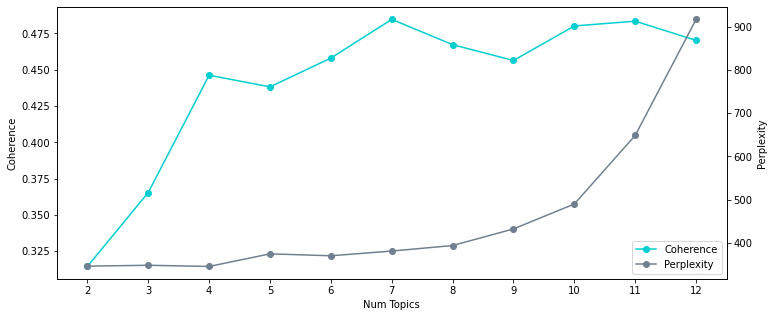

In [7]:
#Metrics for Topic Models
start = 2
limit = 13
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

# evaluation
x = range(start, limit, step)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot()

# coherence
ax1.plot(x, coherence_vals, 'o-', color='darkturquoise', label='Coherence')
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence')

# perplexity
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color='slategray', label='Perplexity')
ax2.set_ylabel('Perplexity')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')

# Vis
ax1.set_xticks(x)
plt.show()

In [8]:
NUM_TOPICS = 7 # Number of Topic

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, random_state=0) # Get model

# Results of clustering
for i in range(len(tweets)):
    score_by_topic = np.zeros(NUM_TOPICS)
    for topic, score in lda_model[corpus[i]]:
        score_by_topic[int(topic)] = float(score)
    if i==0 : 
        Probability = [score_by_topic]
    else:
        Probability = np.append(Probability, [score_by_topic], axis=0)
Probability = np.concatenate([Probability, np.array(data["label"]).reshape(-1,1)], axis=1)

In [9]:
# method returns all topic distributions regardless of size...(Gensim uses sparse vectors by default)
# http://stackoverflow.com/questions/17310933/document-topical-distribution-in-gensim-lda
def get_doc_topics(lda_model, bow):
    gamma, _ = lda_model.inference([bow])
    topic_dist = gamma[0] / sum(gamma[0])
    return [(topic_id, topic_value) for topic_id, topic_value in enumerate(topic_dist)]

word = ['covid-19'] # this may need to be a list in list, it's been a while since I've used Gensim so try just a list first
bow = dictionary.doc2bow(word)
doc_lda = get_doc_topics(lda_model, bow)
dense_vec = matutils.sparse2full(doc_lda, lda_model.num_topics)
print(word, dense_vec)

['covid-19'] [0.07142958 0.07152334 0.07142887 0.57132727 0.07142889 0.07143318
 0.07142883]


In [10]:
keyword = "covid-19"
for n in range(len(tweets)):
    if keyword in tweets[n]:
        print(n, tweets[n], "\n")

4384 &lti am not a doctor but i am fighting too&gt 8 cops have died while fighting covid-19 youngest being 26 300+journalists in hubei/wuhan reporting  6000 personnels on rescue missions all volunteers 4 million community volunteers fighting virus in 650000 communitiessalute  

4472 video china is working on new drugs to fight the novel coronavirus with some early success these are all potential drugs that can help fight the new virus that has affected many people in china  via  response to covid-19 requires tech innovation and response to such emergency takes innovative governance structure and measures china will figure out its own integrated knoledge base such as use of tcm that might be part of china ips  

4541 opinion： though small pockets of racism and discrimination are growing on the fringes of society many more people around the world are condemning such behaviour and standing in solidarity with the people of china in their battle against coronavirus while never underestimati

19174 favipiravir shows good clinical efficacy in treating covid-19 official - xinhua |  

19176 british ambassador  on the measures that we are taking following a uk diplomat testing positive for covid-19 here  please keep up to date with fco travel advice for ethiopia   

19178 commissioner trevor a velinor updates the vi public on the corona virus covid-19    are you a british  national in the usvi please watch this important update from  commissioner trevor velinor   

19188 british ambassador  on the measures that we are taking following a uk diplomat testing positive for covid-19 here  please keep up to date with fco travel advice for ethiopia   the facts of our covid19 case apologies for the quality of the camerawork stay safe   

19208 covid-19 in wuhan was reported to belong to the third generation of covid where is the first generation of gene  and the second generation but now the most important thing is to work together to fight epidemic in facing the outbreak so many parts

28987 the first wards treating critically-ill covid19 patients at tongji hospital in guanggu wuhan saw all patients off on sat a total of 86 covid-19 patients including 22 in critical condition were treated at the hospital 76 of them have recovered  this major test both about professionality of chinese medical workers and technologies including tcm and about how they are organized so that more lives are saved has been passed and written into textbooks governance chinasolutions fightagainstcovid19  

29001 such a dead case of covid-19 has occurred in us  an infected boy was refused by the hospital because he had no medical insurance and soon he died life and money which is more important this is us 

29005 more and more soldiers on the two us fighter carriers are being infected by the covid-19 the two fighter carriers left us quite early this year  and they didn't went to any heavily infected country  how could that happen 

29006 updated covid-19 information for us citizens in india  


42181 1/2 whilst nz remains at alert level 4 in its covid-19 response nz’s pm ardern has announced what a move to covid-19 alert level 3 would look like if and when it happens -   2/2 a decision on whether to move to alert level 3 will be made on monday 20 april more information is available here -  

42198 thank you  let’s join in and encourage everybody to staysafe  spotted   covid-19 message to staysafe  

42216 thanks to excellent teamwork among _bangladesh caab airport officials _police &amp embassy dhaka volunteers a third qatarairways flight departed today returning several hundred american citizens to the usa in response to the covid-19 pandemic safe travels stay well  commercialrescue flights like these have been essential in bringing thousands of americanshome inspiring to see public-private partnerships solve covid19 challenges  

42241 who is spreading covid19 disinformation has china timely informed the world about the covid-19 did china forbid us doctors to be on the grou

55267 we need to work together to contain covid19 plaguing the globe given that this continent is the least infected one for now   recovery of economy whilst avoiding a rebound of covid-19 is something that china now works on sa is also at its key stage let’s join hands  

55278 china’s covid19 vaccine candidate proves effective in protecting monkeys from the novel coronavirus says world’s first report on animal trial results of covid_19 vaccine candidates released in science magazine   encouraging news chinese scientists released world’s first animal trials report of covid-19 vaccine candidate on science magazine showing positive results 

55286 the us military’s health labs have spent $69 million on biosurveillance of the virus that causes covid-19 conducting studies in 30 countries to contain the disease and maintain military readiness  

55316 china reduced the covid-19 infections by 67 fold nature  来自  

55317 tomorrow we reflect on the 75th anniversary of ve day to honor the dedi


66728 alltogether svizajedno coronainfocg  us researchers are joining forces with scientists around the world to find solutions to end the covid-19 pandemic collaboration &amp transparency are essential to solving the world’s great challenges  

66745 covid-19 sanitisation programme launched in table view dunoon  more schools in western cape suspected of having covid-19 positive staff  sa covid-19 positive cases now stand at 24 264 with 43 deaths reported in the last 24 hours  western cape records 39 more covid-19 deaths as confirmed cases rise to 15 756  

66757 no covid-19 cure but chinese herb capsule but shortens fever fatigue and coughing research  tcm works  

66765 are you up for  spaceapps covid-19 challenge  space agencies _asc and  have joined  and _en as partners in this  hackathon  sign up and see you on may 30-31 &gt&gt   spaceapps 2020 is oct 2-4 but the nasa int'l  challenge will hold a virtual hackathon may 30-31 to develop solutions related to the covid19 pandemic reg

79821 amity with neighbors harmony without uniformity and peace are values very much cherished in chinese culture we should champion the spirit of humanity compassion and dedication somaliacovid-19 

79823 culture and civilization are enriched through exchange and mutual learning delicious soup is made by combining different ingredients somalia covid-19 diversity in human civilizations not only defines our world but also drives human progress different histories national conditions ethnic groups and customs give birth to difference civilizations and make the world colorfulsomalia covid-19 

79824 there is no such thing as a superior or inferior civilization civilizations are different only in identity and location diversity in civilizations should not be a source of global conflict rather it should be a driver for progresssomalia covid-19 

79828 every civilization with its own appeal and roots is a human treasure diverse civilizations should draw on each other to achieve common progre


95666 the two sides need to enhance communication and coordination in multilateral fora and on global governance support the un-centered multilateral system and the international order underpinned by international law wang pledged that china will not change the strategic and long-term importance it places on relations with lac  china-lac relations will come through even stronger after covid-19 and have a brighter tomorrow toward a china-lac community with a shared future 

95667 participating ministers spoke highly of lac-china relations and echoed the proposals by state councilor wang they commended china open and responsible efforts since the start of covid-19 to promote international cooperation and experience sharing 

95670 the ministers stressed that the int'l community should uphold multilateralism enhance solidarity &amp collaboration support who in performing its important duty oppose any politicization &amp stigmatization in the name of covid-19 the ministers reaffirmed supp

116557 how are artists entrepreneurs and leaders working with communities in response to the covid-19 crisis join this live discussion on 17 september  connectedbyconversations britishcouncileurope 

116573 the final stage of testing is underway in the  on three potential vaccines for covid-19 a major step toward delivering a vaccine to the world in record time ‍  

116607 'made in wuhan' goes into full swing post pandemic more than 100000 mobile phones are produced in the factory every day and then shipped all over the country and the world from wuhan - the city that emerged from a 76-day lockdown during the covid-19 epidemic  

116609 spokesman for the ministry of national defense said the report titled military and security developments involving the people republic of china 2020 is further proof of the us intent to smear china and its military   chinese state councilor and defense minister wei fenghe visit to malaysia indonesia brunei and the philippines amid the covid-19 pandemic 

In [11]:
print("●Vote:")
for i in [86061, 86063]:
    print(Probability[i][-1], end='\n')
    print(tweets[i], end='\n')
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(Probability[i][n]), end=', ')
    print('{:.2f}'.format(Probability[i][NUM_TOPICS-1]), end="\n\n")
    
print("●Covid-19:")
for i in [14794, 15447]:
    print(Probability[i][-1], end='\n')
    print(tweets[i], end='\n')
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(Probability[i][n]), end=', ')
    print('{:.2f}'.format(Probability[i][NUM_TOPICS-1]), end="\n\n")

print("●Hongkong: ")
for i in [70612, 91829]:
    print(Probability[i][-1], end='\n')
    print(tweets[i], end='\n')
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(Probability[i][n]), end=', ')
    print('{:.2f}'.format(Probability[i][NUM_TOPICS-1]), end="\n\n")
    
print("●Xinjiang: ")
for i in [31682, 78215]:
    print(Probability[i][-1], end='\n')
    print(tweets[i], end='\n')
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(Probability[i][n]), end=', ')
    print('{:.2f}'.format(Probability[i][NUM_TOPICS-1]), end="\n\n")

print("●Visa, Travel: ")
for i in [38, 15120, 17581]:
    print(Probability[i][-1], end='\n')
    print(tweets[i], end='\n')
    for n in range(NUM_TOPICS-1):
        print('{:.2f}'.format(Probability[i][n]), end=', ')
    print('{:.2f}'.format(Probability[i][NUM_TOPICS-1]), end="\n\n")

●Vote:
1.0
absentee voting is fast easy and can be done from anywhere have you registered to vote yet go to  to do it today vote2020 
0.01, 0.01, 0.01, 0.01, 0.70, 0.10, 0.15

1.0
do you think that on election day  voters cast their votes ️ directly for the presidential candidate of their choice no they don’t  information about the electoral college ️  elections elections2020 
0.09, 0.11, 0.13, 0.08, 0.35, 0.13, 0.10

●Covid-19:
2.0
covid-19 pandemic threatening but controllable who chief  来自 
0.25, 0.02, 0.02, 0.65, 0.02, 0.02, 0.02

2.0
spotlight covid-19 outbreak declared pandemic as it takes rising toll in europe  
0.01, 0.01, 0.01, 0.51, 0.21, 0.22, 0.01

●Hongkong: 
2.0
hongkong residents have enjoyed unprecedented rights and freedoms since hongkong’s return to motherland we urge the uk side to step back from the brink abandon cold war &amp colonial mindset and stop interfering in hongkong affairs and other china’s internal affairs  it seems that some country is still nostalgic f

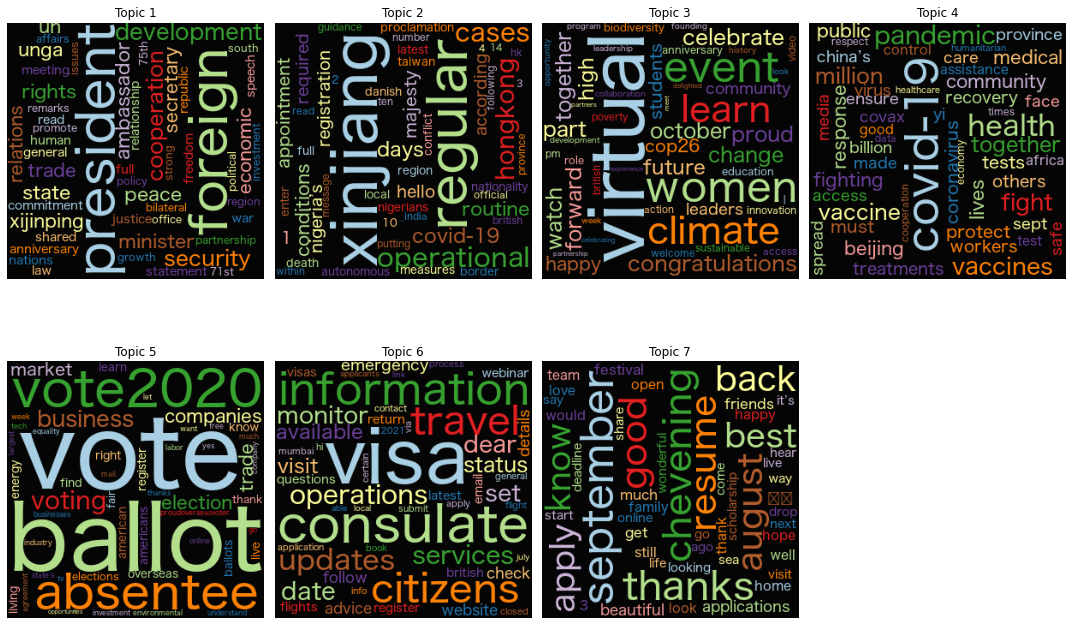

In [26]:
# WordCloud
fig, axs = plt.subplots(ncols=4, nrows=math.ceil(lda_model.num_topics/4), figsize=(15,10))
axs = axs.flatten()

for i in range(lda_model.num_topics):
    x = dict(lda_model.show_topic(i, 50))
    im = WordCloud(
        background_color='black',
        font_path="/system/Library/Fonts/ヒラギノ角ゴシック W4.ttc",
        width=300, height=300,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i+1))
axs.flat[7].set_visible(False)

# vis
plt.tight_layout()
plt.show()
fig.savefig("WordCloud.eps")


Topic 1: right, un, republic, freedom, justice + president, development, xijinping  
Topic 2: xinjiang, hongkong + (numbers)  
Topic 3: virtual, women, event, ..., (mixed topic) + climate, cop26  
Topic 4: covid-19  
Topic 5: vote  
Topic 6: visa, travel  
Topic 7: september, thanks, chevening, ..., (mixed topic)  

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Vis PCoA 
vis_pcoa = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

/Users/goda/miniforge3/envs/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/goda/miniforge3/envs/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/goda/miniforge3/envs/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/goda/miniforge3/envs/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/goda/miniforge3/envs/myenv/lib/python3.9/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.173168  0.231055       1        1  13.136054
1     -0.279445  0.145054       2        1   7.835073
2      0.180578  0.011340       3        1  14.888927
3      0.066751  0.084456       4        1  21.463915
4      0.100739 -0.161060       5        1  10.577164
5     -0.270332 -0.060008       6        1  18.831530
6      0.028541 -0.250836       7        1  13.267336, topic_info=             Term          Freq         Total Category  logprob  loglift
9034     covid-19  19483.000000  19483.000000  Default  30.0000  30.0000
518          visa  11733.000000  11733.000000  Default  29.0000  29.0000
2441    consulate   8205.000000   8205.000000  Default  28.0000  28.0000
378   information   8015.000000   8015.000000  Default  27.0000  27.0000
4658     xinjiang   3799.000000   3799.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1786        still   1181.307962   3214.136260   Topic7  -5.5694   1.0189
343         thank   1281.478190   4344.044545   Topic7  -5.4880   0.7991
362          well   1176.008774   3241.258473   Topic7  -5.5739   1.0060
274          open   1163.330832   3294.517155   Topic7  -5.5847   0.9789
675          look   1135.033415   2996.016453   Topic7  -5.6093   1.0492

[479 rows x 6 columns], token_table=      Topic      Freq Term
term                      
347       1  0.022597    1
347       2  0.421202    1
347       3  0.011750    1
347       4  0.078636    1
347       5  0.000904    1
...     ...       ...  ...
521       3  0.649293    |
521       4  0.091658    |
521       6  0.095206    |
521       7  0.002957    |
1443      7  0.999292   ⁦⁩

[1204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

In [24]:
pyLDAvis.save_html(vis_pcoa, 'pyldavis_output_pcoa.html')

# 3. GEMHP Analysis
## 3.1. Topic model
$\bar{N}$ is GEMHP marked a Markov chaine $\{X_n\}_{n=1, 2, \dots}$ whose intensity is

\[
    \lambda^i(t) = \mu_i + \sum_{j=1}^d \int_{[0,t) \times \mathbb{X}} e^{-(t-s)\beta_{ij}}\bigg( \sum_{l=1}^{d'} m_{ij, l}x_{l} \bigg)\bar{N}^j(ds, dx).\nonumber
\]
Then, parameters are $\{\mu_i\}_i, \{\beta_{ij}\}_{i,j}, \{m_{ij, l}\}_{i,j,l}$．

### Sparse 2-dim GEMHP with LDA mark
\begin{itemize}
	\item Dimension 1 : US
	\item Dimension 2 : CN
	\item Number of Topic : 8
\end{itemize}
\[
    \lambda^i(t) = \mu_i + \sum_{j=1}^2 \int_{[0,t) \times \mathbb{X}} e^{-\beta_{ij}(t-s)} \big(m_1x_1 + \cdots + m_8x_8\big)\bar{N}^j(ds, dx).\nonumber
\]

## 3.2. P-O Estimation
### Setting
Set parameters $\vartheta =  \big( \theta^0, \theta^1, \nu^0, \nu^1 \big) = \big(\{\mu_i\}_i, \{\beta_{ij}\}_{i,j}, \{m_{ij, l}\}_{i,j,l}\big)$, where
\begin{itemize}
	\item $\theta^0 =\{ m_{ijl} | i, j, l \ s.t \ (i, j) \notin \mathcal{J}^0 \}$.
	\item $\theta^1 = \{ \mu_i\}_i \cup \{ \beta_{ij} | i, j \ s.t \ (i, j) \notin \mathcal{J}^0 \}$.
	\item $\nu^0 = \{ m_{ijl} | i, j, l \ s.t \ (i, j) \in \mathcal{J}^0 \}$.
	\item $\nu^1 = \{ \beta_{ij} | i, j \ s.t \ (i, j) \in \mathcal{J}^0 \}$.
    \item $\mathcal{J}^0 = \big\{ (i, j) \big| m^*_{ijl} = 0 \text{ for all } l = 1, \dots d'. \big\}$.
\end{itemize}
### Quasi Log-Likelihood Function
\[
    l_T(\theta) = \sum_{i=1}^d \left\{ \int_0^T \log \lambda^i(t, \theta)N^i(dt) - \int_o^T \lambda^i(t, \theta)dt + \int_{[0,T] \times \mathbb{X}} \log q^i(s, x, \theta) \bar{N}^i(ds, dx) \right\} 
    =: \sum_{i=1}^d \left\{ \mathbb{A}^i_T(\theta) + \mathbb{B}^i_T(\theta) + \mathbb{C}^i_T(\theta) \right\} \nonumber
\]

Let $\tau^i_n$ be the $n$-th jump of $N^i$. If marks are i.i.d. $\sim p(x, \theta)dx$, $\mathbb{A}^i_T(\theta),　\mathbb{B}^i_T(\theta)$ and $\mathbb{C}^i_T(\theta)$ are written as

\[
    \mathbb{A}^i_T(\theta) = \sum_{n=1}^{N^i_T} \log \lambda(\tau^i_n, \theta)
    = \sum_{n=1}^{N^i_T} \log \left( \mu_i + \sum_{j=1}^d \sum_{\tau^j_m < \tau^i_n} \left\langle A_{ij} \Big| e^{-(\tau^i_n - \tau^j_m)B_{ij}} \right\rangle g_{ij}\big(X_{\tau^j_m}, \theta\big) \right), \nonumber
\]

\[
    \mathbb{B}^i_T(\theta) = -\mu_i T + \sum_{j=1}^d \sum_{n=1}^{N^j_T} \sum_{m=1}^{n-1} \left\langle A_{ij} \Big| B^{-1}_{ij} \big( e^{-(\tau^j_n - \tau^j_m)B_{ij}} - e^{-(\tau^j_{n-1} - \tau^j_m)B_{ij}} \big) \right\rangle g_{ij}\big(X_{\tau^j_m}, \theta\big), \nonumber
\]

\[
    \mathbb{C}^i_T(\theta) = \sum_{n=1}^{N^i_T} \log p\big(X_{\tau^i_n}, \theta\big). \nonumber
\]

※ In our case, we only have to consider $\sum_{i=1}^d \left\{ \mathbb{A}^i_T(\theta) + \mathbb{B}^i_T(\theta) \right\}$, and then the computation cost of $l_T(\theta)$ is $O(d^2N_T^2)$.
### P-O Estimator
\begin{itemize}
    \item (Step 1) : We obtain the first estimator by
        \[
            \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big) = argmax_{\vartheta \in \Xi} l_T(\vartheta),\nonumber
        \]
	\item (Step 2) : We obtain the second estimator by
        \[
            \big( \hat{\theta}^{0,(q)}_T, \hat{\nu}^{0,(q)}_T \big) = argmin_{ (\theta^0, \nu^0 ) \in \bar{\Theta}^0 \times \bar{\mathcal{N}}^0} Q^{(q)}_T(\theta^0, \nu^0),\nonumber
        \]
	\item (Step 3) : We obtain the third estimator by
        \[
            \big( \check{\theta}^0_T, \check{\theta}^1_T, \check{\nu}^0_T, \check{\nu}^1_T \big) = argmax_{ \vartheta \in \hat{\Theta}^0_T \times \Theta^1 \times \hat{\mathcal{N}}^0_T \times \mathcal{N}^1} l_T(\vartheta),\nonumber
        \]
	where
	\begin{itemize}
        \item $l_T(\theta)$ : the quasi log-likelihood function,
        \item $Q^{(q)}_T(\theta^0, \nu^0) = \sum_{j=1}^{p_0} \left( \big( \theta^0_j - \tilde{\theta}^0_j \big)^2 + \kappa^{\theta}_j | \theta_j |^q \right) +  \sum_{j=1}^{n_0} \left( \big( \nu^0_j - \tilde{\nu}^0_j \big)^2 +\kappa^{\nu}_j  | \nu_j |^q \right), \kappa_j = T^{-\frac{1+a}{2}}\big| \tilde{\theta}_j + T^{-\frac{1}{2}} \big|^{-\gamma}, q \in (0, 1], \ \gamma > q-1, \ a \in (1-q-\gamma, 0)$
		\item $\hat{\Theta}^0_T = \big\{\theta^0 \in \bar{\Theta}^0 \big| \theta^0_j = 0, j \in \hat{\mathcal{J}}^0_T \big\}$,
		\item $\hat{\mathcal{J}}^0_T = \big\{ j = 1, \dots, p_0 \big| \hat{\theta}^{0, (q)}_j = 0 \big\}$,
		\item $\hat{\mathcal{N}}^0_T = \big\{\nu^0 \in \bar{\mathcal{N}}^0 \big| \nu^0_j = 0, j \in \hat{\mathcal{K}}^0_T \big\}$,
		\item $\hat{\mathcal{K}}^0_T = \big\{ j = 1, \dots, n_0 \big| \hat{\nu}^{0, (q)}_j = 0 \big\}$.
	\end{itemize}
\end{itemize}

In [14]:
## parameter：params = [mu, alpha, beta, m, paramsMark, initEps] (list)
### mu : d-dim Vector (np.array)
### alpha : [d, d, p]-dim Tensor (np.array)
### beta : [d, d]-dim Matrix (np.array)
### m : [d, d, d'+1]-dim Tensor (np.array)
### paramsMark: parameter for mark density
### initEps : [d, d, p, p]-dim Tensor (np.array), the initial value of elementary excitation process

## Polynomial Type Excitation Kernel w.r.t. time
def PolyExpKernel(time, params):
    ## time : : [time, ...], len(time)-dim Vector or float, int
    ## params : all parameters
    alpha = params[1]
    dim = len(params[0])
    d_alpha = len(alpha[0,0])
    #casting
    if type(time) != np.ndarray:
        time = np.array(time).reshape(1,1)
    else:
        time = np.array(time).reshape(len(time),1)
            
    fact = np.vectorize(np.math.factorial)(np.arange(d_alpha)) # [1!, 2!, 3!,...]
    components = time**np.arange(d_alpha)/fact # Ploynomial type
    expt = components[:, :d_alpha]
    for i in range(1, d_alpha):
        exptcol = np.append(np.zeros((len(time), i)), components[:, :d_alpha-i], axis=1)
        expt = np.append(expt, exptcol, axis=1)
    expt = expt.reshape(len(time), d_alpha, d_alpha)
    
    A = np.zeros((dim, dim, d_alpha, d_alpha))
    for i in range(dim):
        for j in range(dim):
            A[i,j,0] = alpha[i,j]*fact
    
    return A, expt
## Linear impact from mark
def gLinear(mark, params):
    ## mark : [x, ...], [len(mark), d']-dim matrix
    ## params_m : m_{i,j,l}, [d, d, d']-dim Tensor     
    _dim = len(params[0]) 
    #if params[3].size == 0:
    #    m = np.concatenate([np.ones((_dim, _dim, 1)), np.zeros((_dim, _dim, 1))], axis=2)
    #else:
    m = params[3]
    if mark.ndim==1: mark = mark.reshape(1, len(mark)) # casting
    #_mark = np.append(np.ones((len(mark), 1)), mark, axis=1) # Add Constant Term
    return (m@mark.T).transpose(2,0,1)
## General Excitation Kernel
def Excitor(Eps, JumpDim, mark, params, kernel = PolyExpKernel, g = gLinear):
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## JumpDim : Dimension of the last jump
    ## mark : [x, ...], [len(mark), d']-dim matrix or d'-dim Vector
    ## params : all parameters
    ## kernel : Excitation function for time
    ## g : Excitation function for mark
    mu = params[0]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    JumpDim = int(JumpDim) # casting
    _intensity = mu.copy()
    _newEps = Eps.copy()
    _A, _exp0 = PolyExpKernel(0, params)
    _exp0 = _exp0[0]
    
    _g = g(mark, params)[0]
    
    for i in range(dim):
            _newEps[i,JumpDim-1] += _exp0*_g[i,JumpDim-1]
            for j in range(dim):
                _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps
def Attenuator(delta, Eps, params, kernel = PolyExpKernel):
    ## delta : time interval
    ## Eps : elementary excitation process, [d, d, p, p]-dim Tensor
    ## prarms : params
    ## kernel : Excitation function for time
    mu = params[0]
    beta = params[2]
    dim = len(mu)
    d_alpha = len(params[1][0,0])
    
    _intensity = mu.copy()
    _newEps = np.zeros((dim, dim, d_alpha, d_alpha))
    _A, _expt = PolyExpKernel(delta, params)
    _expt = _expt[0]

    for i in range(dim):
        for j in range(dim):
            _newEps[i,j] = np.exp(-beta[i,j]*delta)*_expt@Eps[i,j]
            _intensity[i] += np.sum(_A[i,j]*_newEps[i,j])

    return _intensity, _newEps          
## Examples of markDist
def markMultiUnif(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _low = paramsMark[0]
    _high = paramsMark[1]
    return np.random.uniform(_low, _high, (size, markDim))
def markMultiDirichlet(preValue, paramsMark, JumpDim, size=1, markDim=1):
    _alpha = paramsMark[0]
    return np.random.dirichlet(_alpha, size)
## Conditional Expected Size of Jump by Monte Carlo Simulation for the judge of Stability
## IID Mark Case, (Spectral radius of Phi) < 1 → Stable
def ComputeG(x, params, markDist, g = gLinear, MC = 100000, markDim=1):
    dim = len(params[0])
    _G = np.zeros((dim, dim)) 
    for j in range(dim):
        sample = markDist(x, params[4], JumpDim=j, size=MC, markDim=markDim)
        g_j = g(sample, params)
        for i in range(dim):
            _G[i,j] = np.sum(g_j[:,i,j])/MC
    return _G
def ComputeB(params):
    ## params : all parameters
    _beta = params[2]
    dim = len(params[0])
    d_alpha = len(params[1][0,0])
    _B = np.zeros((dim, dim, d_alpha, d_alpha))
    _M = np.zeros((d_alpha, d_alpha))
    
    for i in range(d_alpha):
        for j in range(d_alpha):
            if j==i+1: _M[i,j] = 1
    for i in range(dim):
        for j in range(dim):
            _B[i,j] = _beta[i,j]*np.eye(d_alpha) - _M
    return _B
def Phi(x, params, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear, MC = 10000):
    dim, _, _, markDim = dims
    
    _A, _ = kernel(0, params)
    _B = ComputeB(params)
    _G = ComputeG(x, params, markDist, g, MC, markDim)
    _Phi = np.zeros((dim, dim))
    for i in range(dim):
        for j in range(dim):
            _invB = np.linalg.inv(_B[i,j])
            _Phi[i,j] = np.sum(_A[i,j]*_invB)*_G[i,j]
    return _Phi
# Sum of the max increment of deac dimensional Kernel 
def MaxKernelUnifMark(params, dims, JumpDim, kernel=PolyExpKernel):
    _Eps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
    InitIntensity, _Eps = Excitor(_Eps, JumpDim, np.array([1.]*dims[3]), params, kernel) # Unif mark <= 1
    MaxInc = 0.
    for i in range(len(params[0])):
        seq = np.arange(0, 10, 0.1)
        y = np.zeros(len(seq))
        for n in range(len(seq)):
            y[n] = Attenuator(seq[n], _Eps, params, kernel)[0][i]
        MaxInc += np.max(y)-InitIntensity[i]
    return MaxInc
############################################################################
############################################################################
## Simulate Hawkes time series with Ogata's method
def simulateGEMHP(params, t_max, dims, markDist = markMultiDirichlet, kernel = PolyExpKernel, g = gLinear):
    _params = params.copy()
    #MaxInc = MaxKernelUnifMark(_params, dims, 0, kernel) # JumpDimに依存したりMarkの上限が1でない場合は要修正
    dim, _, d_mark, markDim = dims
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    paramsMark, initEps = _params[4], _params[5]
    arrivals = np.array([[0,1]]) # each jump times (t_{i,0} = 0 for all i)
    for i in range(1,dim):
        arrivals = np.append(arrivals, np.array([[0,i+1]]), axis=0)
    x = np.zeros(d_mark)
    marks = np.zeros((1,d_mark+1)) # each marks
    delta = 0 # last jump time interarrival
    t = 0 # last jump time

    ### Case: first jump
    # Calculate now intensity at t = 0
    # and consider the 1-dim P.P. with intensity lambda_bar
    intensity, Eps = Attenuator(0, initEps, _params)
    lambda_bar = np.sum(intensity)#+MaxInc 
    delta = -np.log(np.random.uniform())/lambda_bar
    t = delta
    if t>t_max:
        for i in range(dim):
            arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
        return arrivals, marks[1:]

    # Calculate now intensity at t = delta- (※ not jump yet!)
    intensity, Eps = Attenuator(delta, Eps, _params, kernel)

    ## Searching for which dimension a jump is occuring in
    D = np.random.uniform()
    cum_lambda = np.sum(intensity)
    if D*lambda_bar<cum_lambda:
        # Searching for the first k such that D*lambda <= cum_lambda_k
        k = 1 # JumpDim
        cum_lambda_k = np.sum(intensity[:k])
        while D*lambda_bar>cum_lambda_k:
            k += 1
            cum_lambda_k = np.sum(intensity[:k])
        arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
        x = markDist(x, paramsMark, k, markDim=markDim)
        marks = np.append(marks, [np.append(x[0],k)], axis=0)
    else:# there are no jumps
        k = 0

    ### Case: other jumps
    while t < t_max:
        # Calculate now intensity at t = t+
        # and consider the 1-dim P.P. with intensity lambda_bar
        if k!=0: 
            intensity, Eps = Excitor(Eps, k, x, _params, kernel, g)
        lambda_bar = np.sum(intensity)#+MaxInc
        delta = -np.log(np.random.uniform())/lambda_bar
        t = t + delta
        if t > t_max:
            for i in range(dim):
                arrivals = np.append(arrivals, np.array([[t_max,i+1]]), axis=0)
            return arrivals, marks[1:]

        # calculate now intensity at t = t + s-
        intensity, Eps = Attenuator(delta, Eps, _params, kernel)

        ## Searching for which dimension a jump is occuring in
        D = np.random.uniform()
        cum_lambda = np.sum(intensity)
        if D*lambda_bar<cum_lambda:
            # Searching for the first k such that D*lambda <= cum_lambda_k
            k = 1
            cum_lambda_k = np.sum(intensity[:k])
            while D*lambda_bar>cum_lambda_k:
                k += 1
                cum_lambda_k = np.sum(intensity[:k])
            arrivals = np.append(arrivals, np.array([[t,k]]), axis=0)
            x = markDist(x, paramsMark, k, markDim=markDim)
            marks = np.append(marks, [np.append(x[0],k)], axis=0)
        else:# there are no jumps
            k = 0
############################################################################
############################################################################            
## Params Cast w.r.t. Hawkes where we fix alpha=1 in our Toic model
def ParamsToVector(params): # Drop alpha
    ## Initial Eps is ignored
    mu = params[0]
    beta = params[2].reshape(1, -1)[0]
    m = params[3].reshape(1, -1)[0]
    return np.concatenate([mu, beta, m])  
def ParamsToList(paramsVector, dims, TrueParamsMark = None, initEps = None): # Attach alpha
    dim, d_alpha, d_mark, MarkDim = dims
    preID, ID = 0, dim
    if paramsVector[preID:ID].size == 0:
        mu = np.array([])
    else:
        mu = paramsVector[preID:ID]
    preID, ID = ID, ID + dim*dim
    if paramsVector[preID:ID].size == 0:
        beta = np.array([])
    else:
        beta = paramsVector[preID:ID].reshape(dim, dim)
    preID, ID = ID, ID + dim*dim*(d_mark)
    if paramsVector[preID:ID].size == 0:
        m = np.array([])
    else:
        m = paramsVector[preID:ID].reshape(dim, dim, d_mark)
    alpha = np.array([1]*(dim**2)).reshape(dim, dim, d_alpha)
    paramsMark = TrueParamsMark
    if initEps == None:
        initEps = np.zeros((dim, dim, d_alpha, d_alpha)) # if initEps = None, it is 0
    return [mu, alpha, beta, m, paramsMark, initEps]
## (-1)*log-likelihood function
def LogLikelihood(paramsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, TrueParamsMark = args
    _mu, _alpha, _beta, _m, _paramsMark, _initEps = ParamsToList(paramsVector, dims, TrueParamsMark=TrueParamsMark)
    _params = [_mu, _alpha, _beta, _m, _paramsMark, _initEps]
    #if max(abs(LA.eig(Phi(0, _params, dims))[0]))>1 or max(abs(LA.eig(Phi(0, _params, dims))[0]))<1e-5: # Check the Stability
    #    print(max(abs(LA.eig(Phi(0, _params, dims))[0])))
    #    return 10e+10
    dim, d_alpha, d_mark, MarkDim = dims
    t_max = arrivals[-1][0]
    _A = np.ones((dim, dim, d_alpha, d_alpha)) # Topic model ver 
    _invB = np.linalg.inv(ComputeB(_params))
    
    times = [] # arrival times for each dim : [[\tau^1_1,...], [\tau^2_1,...], ...]
    mark = [] # marks for each dim : [[X_{\tau^1_1}, ... ], [X_{\tau^2_1}, ... ], ...]
    gValues = [] # [g(X_{\tau_1}), g(X_{\tau_2}), ...]
    for i in range(dim):
        times.append((arrivals[arrivals.T[:][1] == i+1]).T[:][0][1:])
        mark.append(marks[marks.T[:][-1] == i+1][:,:-1])
        gValues.append(g(mark[-1], _params))
        
    # log-likelihood
    bbA, bbB = np.zeros(dim), -_mu*t_max
    for i in range(dim):
        for j in range(dim):
            for n in range(1,len(times[j])):
                # Bの計算
                dtime1 = times[j][n]-times[j][:n]
                dtime2 = np.append(times[j][n-1]-times[j][:n-1],0)
                exptB1 = np.exp(-_beta[i,j]*dtime1)
                exptB2 = np.exp(-_beta[i,j]*dtime2)
                bbB[i] += np.sum(_invB[i,j,0,0]*(exptB1-exptB2)*gValues[j][:n,i,j]) # Topic model ver 
                
        for n in range(len(times[i]))[:-1]:
            expbbAi = _mu[i]
            # Aの計算
            for j in range(dim):
                num = np.sum(times[j][:]<times[i][n])
                dtime3 = times[i][n]-times[j][:num]
                exptB3 = np.exp(-_beta[i,j]*dtime3)
                expbbAi += np.sum(exptB3*gValues[j][:num,i,j]) # Topic model ver 
            bbA[i] += np.log(expbbAi)
    
            #print("bbA", bbA[i])
    #print(paramsVector)
    return (-1)*(np.sum(bbA+bbB))
############################################################################
############################################################################
##　Generate Path of Intensity
def Intensity(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear):
    # Output : Res = np.array([[value of intensity, time, dim], ...])
    _params = params.copy()
    dim = len(_params[0])
    if _params[3].size == 0: _params[3] = np.concatenate([np.ones((dim, dim, 1)), np.zeros((dim, dim, 1))], axis=2)
    mu, alpha, beta, m, paramsMark, initEps = _params
    d_alpha, d_mark = len(alpha[0,0]), len(m[0,0])-1
    
    ## Initial Value
    intensity, Eps = Attenuator(0, initEps, _params, kernel)
    Res = np.concatenate([[intensity], [np.zeros(dim)], [range(1,dim+1)]]).T

    ## Values of Intensity
    for i in range(dim-1, len(arrivals)-(dim-1)-1): # 最初と最後は打点がdim個だけ被っているため，取り除いて考える
        t_seq = np.arange(arrivals[i][0], arrivals[i+1][0], delta) # intervalを間隔deltaで刻む
        if len(t_seq)==0 : continue
        for t in t_seq:
            intensity, Eps = Attenuator(delta, Eps, _params, kernel)
            Res = np.append(Res, np.array([intensity, np.repeat(t, dim), range(1,dim+1)]).T, axis=0)
        # seqで間引かれるため，最後の点は別途計算
        intensity, Eps = Attenuator(arrivals[i+1][0] - t_seq[-1], Eps, _params, kernel)
        Res = np.append(Res, np.array([intensity, np.repeat(arrivals[i+1][0], dim), range(1,dim+1)]).T, axis=0)
        # Jumpさせる
        if i < len(arrivals)-(dim-1)-2: # Marksのサイズはarrivalと異なることに注意
            intensity, Eps = Excitor(Eps, marks[i+1-dim, -1], marks[i+1-dim, :-1], _params, kernel, g)

    return Res
## Function for Plot (xlabel is date)
def GEMHP_Plot(arrivals, marks, delta, params, kernel = PolyExpKernel, g = gLinear, SavePath="", MarkPlot= True):
    # Simulation p.p.
    t_max = arrivals[-1][0]
    # Simulation intensity
    _Intensity = Intensity(arrivals, marks, delta, params, kernel, g)
    
    # plot用の画面分割
    dim = len(params[0])
    markDim = len(marks[0])-1
    if MarkPlot:
        fig = plt.figure(figsize=(20, 4*(2+markDim)/dim))
        gs = gridspec.GridSpec(4+markDim,dim)
    else:
        fig = plt.figure(figsize=(20, 8/dim))
        gs = gridspec.GridSpec(4,dim)
        
    plt.subplots_adjust(top=0.92, bottom=0.2, hspace=0., wspace=0.2)
    day = int(arrivals[-1][0]/6)+1
    x = pd.date_range('2020-1-31', periods=int(arrivals[-1][0]/day+1), freq=str(day)+'D').strftime("%m-%d-'%y")
    new_xticks = list(range(0,int(arrivals[-1][0])+1,day))  # 点がない場所でも良い

    for i in range(dim):
        time = arrivals[arrivals.T[:][1]==i+1]
        time = time.T[:][0]
        N = np.append(np.array(range(len(time)-1)), len(time)-2)     
        ax = fig.add_subplot(gs[0:2,i])
        ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
        #ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        ax.set_ylabel("$N^{%d}$" %(i+1), fontsize=15)
        ax.grid()
        
        lambda_i = _Intensity[_Intensity.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]
        ax = fig.add_subplot(gs[2:4,i])
        ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
        #ax.set_xlim([-t_max*0.03, t_max*1.03])
        ax.set_ylim([0, max(lambda_i)*1.1])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(params[0][i], ls = "-.", color = "magenta")
        ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=15)
        ax.grid()
        
        if MarkPlot:
            for j in range(markDim):
                time = arrivals.T[:][0][dim:-dim]
                ax = fig.add_subplot(gs[4+j,i])
                ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
                #ax.set_xlim([-t_max*0.03, t_max*1.03])
                ax.set_ylim([0, 1.3])
                ax.bar(time, marks[:,j], width=t_max*0.002, color="green")
                ax.set_ylabel("Topic $%d$" %(j+1), fontsize=10)
                ax.grid()
        ax.xaxis.set_ticklabels(x)  
        ax.set_xlabel("date", fontsize=15)

    fig.suptitle('GEMHP Plot', fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
############################################################################
############################################################################       
# Step. 1. : Estimate MLE by LogLikelihood
# Step. 2.a. : Extract possibly zero components from MLE by LSAParams
# Step. 2.b. : Estimate LSAE by LSA
# Step 3.a. : Extract zero components from LSAE by LSAParams
# Step 3.b : Estimate P-O by ElimLogLikelihood
# Extract possibly zero components (mu, m) for ElimZeroParams
def LSAParams(paramsVector, dims, bounds):
    dim, d_alpha, d_mark, markDim = dims
    LSAParamsVector = np.concatenate([paramsVector[:dim], paramsVector[-(d_mark*dim**2)-1:]])
    low_bd = np.concatenate([bounds[0][:dim], bounds[0][-(d_mark*dim**2)-1:]])
    up_bd = np.concatenate([bounds[1][:dim], bounds[1][-(d_mark*dim**2)-1:]])
    LSABounds = [low_bd, up_bd]
    return LSAParamsVector, LSABounds
# Reconstruct full parameter from LSAParamsVector.
def ReconstLSAParams(LSAParamsVector, paramsVector, dims):
    dim, d_alpha, d_mark, markDim = dims
    ParamsVector = np.concatenate([LSAParamsVector[:dim], paramsVector[dim:-(d_mark*dim**2)-1], LSAParamsVector[-(d_mark*dim**2)-1:]])
    return ParamsVector
# Eliminate zero components
def ElimZeroParams(paramsVector, bounds):
    nonZeroId = paramsVector!=0
    elimParamsVector = paramsVector[nonZeroId]
    low_bd = bounds[0][nonZeroId].tolist()
    up_bd = bounds[1][nonZeroId]
    elimBounds = [low_bd, up_bd]
    return elimParamsVector, nonZeroId, elimBounds
# Reconstruct full parameter from elimParamsVector.
def ReconstZeroParams(elimParamsVector, nonZeroId):
    paramsVector = np.array(nonZeroId, float) # Zero params are zero
    paramsVector[nonZeroId] = elimParamsVector
    return paramsVector
# Objective function (Least Square Approximation)
def LSA(zeroParamsVector, args): 
    zeroPreEstVector, dims, t_max, gamma, a, q = args # where zeroPreEstVector = LSAParams(preEstVector, dims)
    kappa = t_max**(-(1+a)/2)*(zeroPreEstVector+1.0e-5*t_max**(-1/2))**(-gamma) # 罰則項係数．
    lsa = np.sum((zeroParamsVector-zeroPreEstVector)**2 + kappa*zeroParamsVector**q)
    return lsa
# Objective function (LogLikelihood)
def ElimLogLikelihood(elimParamsVector, args, kernel = PolyExpKernel, g = gLinear):
    arrivals, marks, dims, paramsMark, nonZeroId = args
    paramsVector = ReconstZeroParams(elimParamsVector, nonZeroId)
    return LogLikelihood(paramsVector, [arrivals, marks, dims, paramsMark], kernel, g)
# Step1: LSE -> Step2: LSA -> Step3: QMLE
# bounds1, bounds2はlistで渡し，full paramsに対して定義しておく．Step2ではbounds1を，Step3ではbounds2を間引いて使用する．
# optionsで条件を緩くしている
def PO(args, x0, bounds, method='L-BFGS-B', gamma=2., a=0.5, q=1., text=True, 
       options={'disp': None, 'maxcor': 10, 'ftol': 1e-08, 'gtol': 1e-04, 'eps': 1e-07,
                'maxfun': 10000, 'maxiter': 10000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None}):
    arrivals, marks, dims, paramsMark = args
    Bounds = optimize.Bounds(bounds[0], bounds[1])
    #initValue = x0 + np.random.uniform(size=len(x0))*1.0e-3 # noize for initial value
    if text:
        start = time.time()
    mle = optimize.minimize(fun=LogLikelihood, x0=x0, args=args, method='L-BFGS-B', bounds=Bounds, options=options)
    if text:
        print('1st QMLE:', '\n', mle, "\n")
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAMLEVector, LSABounds = LSAParams(mle.x, dims, bounds)
    LSABounds = optimize.Bounds(LSABounds[0], LSABounds[1])
    argsLSA = [LSAMLEVector, dims, arrivals[-1][0], gamma, a, q]
    lsae = optimize.minimize(fun=LSA, x0=LSAMLEVector, args=argsLSA, method='L-BFGS-B', bounds=LSABounds)
    if text:
        print('2nd LSAE:', '\n', lsae, '\n')
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAVector = ReconstLSAParams(lsae.x, mle.x, dims)
    elimLSAVector, nonZeroId, elimBounds = ElimZeroParams(LSAVector, bounds)
    elimBounds = optimize.Bounds(elimBounds[0], elimBounds[1])
    argsElimMLE = [arrivals, marks, dims, paramsMark, nonZeroId]
    elimpoe = optimize.minimize(fun=ElimLogLikelihood, x0=elimLSAVector, args=argsElimMLE, method='L-BFGS-B', bounds=elimBounds, options=options)
    
    if text:
        print('3rd POE:', '\n', elimpoe)
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    poe = ReconstZeroParams(elimpoe.x, nonZeroId)

    return poe, mle.x

<>:381: DeprecationWarning: invalid escape sequence \l
<>:381: DeprecationWarning: invalid escape sequence \l
/var/folders/hj/3f05400915j8h6fz_b6yxh580000gq/T/ipykernel_25001/2284816652.py:381: DeprecationWarning: invalid escape sequence \l
  ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=15)


Process the data into the form of a marked point process.
\begin{itemize}
    \item $arrivals = [(\tau_1, \kappa_1), (\tau_2, \kappa_2), \cdots]$,
    \item $marks = [(X_1, \kappa_1), (X_2, \kappa_2), \cdots]$,
\end{itemize}
where
\begin{itemize}
    \item $\tau_n$ : the n-th jump time of $\sum_{i=1}^d N_T^i$,
    \item $\kappa_n$ : the dimension of the n-th jump,
    \item $X_n$ : the mark of the n-th jump ( conditional probability $p(z|w)$ by LDA ),
\end{itemize}

In [15]:
def getSample(data, Probability, SampleNum = 1000, label = 3):
    if SampleNum=="all":
        SampleData = data
        marks = Probability
    else:
        SampleData = data[:SampleNum]
        marks = Probability[:SampleNum]
    arrivals = []
    for i in range(1, label+1):
        arrivals.append([0, i])
    arrivals.append([SampleData["Elapsed_time"][0], SampleData["label"][0]])
    for i in range(1, SampleData.shape[0]):
        if SampleData["Elapsed_time"][i]<=arrivals[-1][0]:
            arrivals.append([arrivals[-1][0]+1.0e-10, SampleData["label"][i]])
        else:
            arrivals.append([SampleData["Elapsed_time"][i], SampleData["label"][i]])
    LastTime = arrivals[-1][0]
    for i in range(1, label+1):
        arrivals.append([LastTime+1.0e-10, i])
    arrivals = np.array(arrivals)
    return arrivals, marks

In [16]:
SampleNum = 'all'
arrivals, marks = getSample(data, Probability, SampleNum)

dims = [3, 1, NUM_TOPICS, NUM_TOPICS] # dim, d_alpha, d_mark (= d, p, d') , dim of mark
mu = np.tile(15, dims[0])
alpha = np.tile(1, (dims[0],dims[0],dims[1]))
beta = np.tile(50, (dims[0],dims[0]))
m = np.tile(10, (dims[0],dims[0],dims[2]))
paramsMark = [np.tile(1, dims[3])] # Dirichlet Param # 今回の解析では影響なし
initEps = np.zeros((dims[0], dims[0], dims[1], dims[1]))
params = [mu, alpha, beta, m, paramsMark, initEps]
paramsVector = ParamsToVector(params)

args = [arrivals, marks, dims, paramsMark]

In [17]:
## Estimation
#low_bd, up_bd = [1.e-10]*len(paramsVector), [1.e+10]*len(paramsVector)
#bounds = optimize.Bounds(low_bd, up_bd) # Bounds for parameter
low_bd, up_bd = np.repeat(0., len(paramsVector)), np.repeat(1.e+10, len(paramsVector))
low_bd[:-(dims[2]*dims[0]**2)] += 0.0001
bounds = [low_bd, up_bd] # Bounds for parameter
out, _ = PO(args, paramsVector, bounds)
labels = ["mu", "alpha", "beta", "m"]
ListPOE = ParamsToList(out, dims, TrueParamsMark=paramsMark)
for i in range(4):
    if i==1: continue
    print("Est", labels[i],  ":", np.round(ListPOE[i], 5), "\n")

1st QMLE: 
       fun: -541771.1526711199
 hess_inv: <75x75 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00465661, -0.00814907, -0.21304004,  0.04423782, -0.12340025,
       -0.01164153,  0.02095476,  0.27008356, -0.11408702,  0.38649886,
       -0.00232831,  0.51339156, -0.00814907, -0.0174623 , -0.01280569,
       -0.01629814, -0.00698492, -0.1268927 , -0.01047738, -0.00931323,
       -0.00582077, -0.0349246 ,  0.05005859, -0.00698492,  0.00698492,
        0.22817403, -0.03259629, -0.02910383, -0.02561137, -0.03608875,
        0.30035153, -0.02910383,  0.74389391, -0.11292286,  0.09778887,
       -0.08731149, -0.10244548, -0.09895302,  1.96043402,  0.13853423,
       -0.00582077, -0.03376044, -0.01396984, -0.12107193, -0.02095476,
       -0.04773028, -0.00232831, -0.02910383, -0.03026798, -0.03026798,
       -0.03958121, -0.05587935, -0.07450581, -0.0372529 , -0.14901161,
       -0.05820766, -0.27823262, -0.06984919, -0.11757948, -0.12340024,
       -0.14668331,  0.45

In [18]:
pd.DataFrame(out).to_csv("./Estimator/USCNGB_POE3.csv")

In [19]:
out = np.array(pd.read_csv("./Estimator/USCNGB_POE2.csv"))[:,1]

The top figure shows the counting process N. The second figure from the top shows the intensity process. The lower figures show the size of the mark.

In [20]:
def GEMHP_Plot_AveMean(arrivals, marks, params, delta=0.001, aveNum=50, kernel = PolyExpKernel, g = gLinear, SavePath="", MarkPlot= True):
    # Simulation p.p.
    t_max = arrivals[-1][0]
    # Simulation intensity
    _Intensity = Intensity(arrivals, marks, delta, params, kernel, g)
    
    # plot用の画面分割
    dim = len(params[0])
    markDim = len(marks[0])-1
    if MarkPlot:
        fig = plt.figure(figsize=(20, 4*(2+markDim)/dim))
        gs = gridspec.GridSpec(4+markDim,dim)
    else:
        fig = plt.figure(figsize=(20, 8/dim))
        gs = gridspec.GridSpec(4,dim)
        
    plt.subplots_adjust(top=0.92, bottom=0.2, hspace=0., wspace=0.2)
    day = int(arrivals[-1][0]/6)+1
    x = pd.date_range('2020-1-31', periods=int(arrivals[-1][0]/day+1), freq=str(day)+'D').strftime("%m-%d-'%y")
    new_xticks = list(range(0,int(arrivals[-1][0])+1,day))  # 点がない場所でも良い

    for i in range(dim):
        time = arrivals[arrivals.T[:][1]==i+1]
        time = time.T[:][0]
        N = np.append(np.array(range(len(time)-1)), len(time)-2)     
        ax = fig.add_subplot(gs[0:2,i])
        ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
        ax.plot(time, N,  color='red', drawstyle='steps-post')
        ax.set_ylabel("$N^{%d}$" %(i+1), fontsize=15)
        ax.grid()
        
        lambda_i = _Intensity[_Intensity.T[:][2]==i+1]
        time = lambda_i.T[:][1]
        lambda_i = lambda_i.T[:][0]
        ax = fig.add_subplot(gs[2:4,i])
        ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
        ax.set_ylim([0, max(lambda_i)*1.1])
        ax.plot(time, lambda_i,  color='blue')
        ax.axhline(params[0][i], ls = "-.", color = "magenta")
        ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=15)
        ax.grid()
        
        time = arrivals[arrivals.T[:][1]==i+1]
        time = time.T[:][0]
        if MarkPlot:
            for j in range(markDim):
                #time = arrivals.T[:][0][dim:-dim]
                mark = marks[marks.T[:][-1]==i+1]
                mark = mark.T[:][j]
                ax = fig.add_subplot(gs[4+j,i])
                ax.xaxis.set_major_locator(ticker.FixedLocator(new_xticks))
                aveMark = pd.Series(mark).rolling(window=aveNum).mean()
                ax.set_ylim([-0.1, 0.7])
                ax.plot(time[1:-1], aveMark, color="green")
                ax.set_ylabel("Topic $%d$" %(j+1), fontsize=10)
                ax.grid()
        ax.xaxis.set_ticklabels(x)  
        ax.set_xlabel("date", fontsize=15)

    fig.suptitle('GEMHP Plot', fontsize=25)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)

<>:40: DeprecationWarning: invalid escape sequence \l
<>:40: DeprecationWarning: invalid escape sequence \l
/var/folders/hj/3f05400915j8h6fz_b6yxh580000gq/T/ipykernel_25001/2419595508.py:40: DeprecationWarning: invalid escape sequence \l
  ax.set_ylabel("$\lambda^{%d}$" %(i+1), fontsize=15)


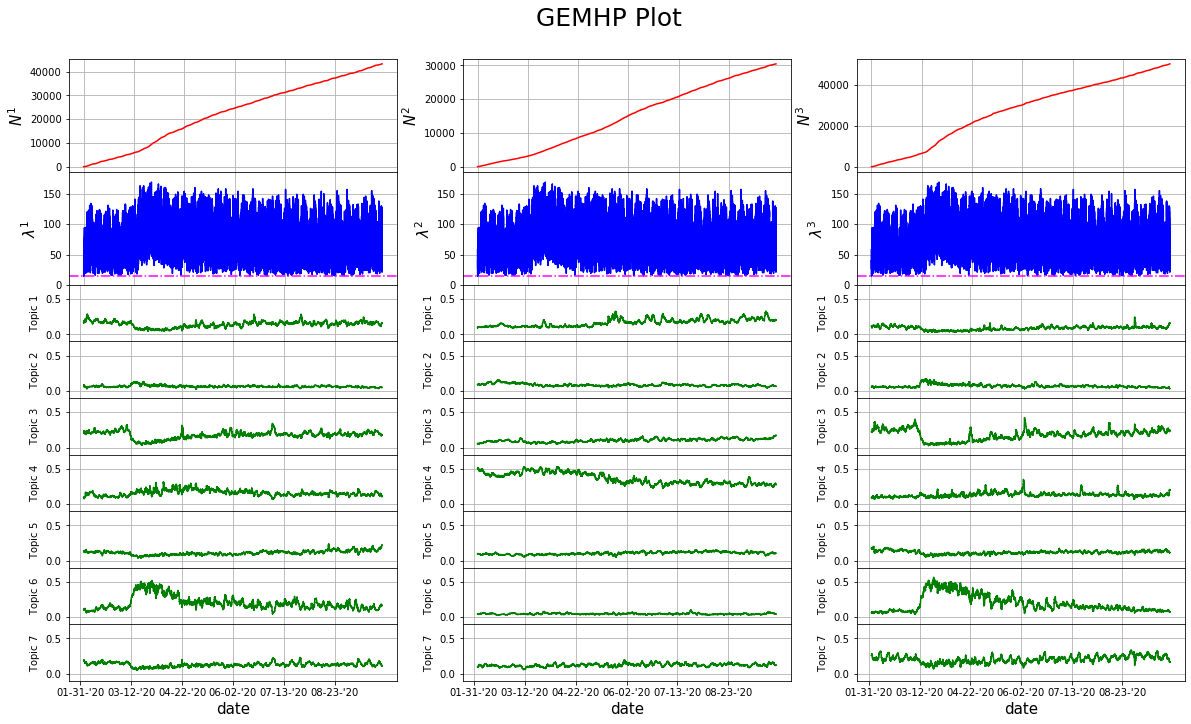

In [21]:
GEMHP_Plot_AveMean(arrivals, marks, params=params, delta=0.001, aveNum=200)